# Emerging Technologies Project
## Cathal Butler | G00346889    
### References
* https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/index.html?index=..%2F..index#0
* https://www.tensorflow.org/guide/data_performance
* https://codelabs.developers.google.com/codelabs/keras-flowers-data/#3
* https://keras.io/examples/mnist_cnn/
* https://www.ics.uci.edu/~mohamadt/keras_mnist.html
* https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# The number of training examples in one forward/backward pass. 
# The higher the batch size, the more memory space you'll need.
batch_size = 128
num_classes = 10
# Setting the number of forward passes and backward passes of all the training examples
epochs = 10
# input image dimensions
img_rows, img_cols = 28, 28

## Load Data set

In [30]:
# Load data. The data, split between train and test sets:
(x_train, y_train), (X_test, y_test) = mnist.load_data()
# Print the original X & Y train shape:
print("Original X shape", x_train.shape)
print("Original Y shape", y_train.shape)

# Reshape data.
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:   
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 # Original data is uint8 (0-255). Scale it to range [0,1].
x_test  /= 255
print("Training X matrix shape", x_train.shape)
print("Testing X matrix shape", X_test.shape)
print (y_train[0])    
    
# Represent the targets as one-hot vectors: e.g. 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0].
nb_classes = 10
# Printing out the training and testing matrix shape
print("Training Y matrix shape", y_train.shape)
print("Testing Y matrix shape", y_test.shape)

Original X shape (60000, 28, 28)
Original Y shape (60000,)
Training X matrix shape (60000, 28, 28, 1)
Testing X matrix shape (10000, 28, 28)
5
Training Y matrix shape (60000,)
Testing Y matrix shape (10000,)


## Example Data

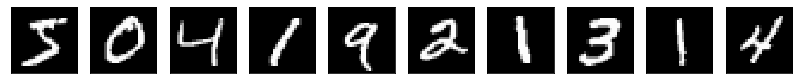

In [31]:
# Plot examples of the data.
plt.figure(1, figsize=(14,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

In [32]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes )


## Keras Model
More information on Keras Sequential Models [here](https://keras.io/getting-started/sequential-model-guide/)

* Convolution Layer: This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
    
    * Activation functions:
        * Relu(Rectified Linear Unit):
            
           Relu would typically be used for all layers but the last. For the last layer softmax activation could be used.
           
        * SoftMax:
            
            Softmax is used on the last layer and has an set amount of classes. It should output 10 numbers 
            between 0 and 1 representing the probability of this digit being a 0, a 1, a 2 and so on.
          

In [33]:
# Keras Model
model = Sequential()
# Convolution Layer:
# Input images with 3 channels:
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Unflattened data
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

## Keras Model Summary

In [34]:
# Keras Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)              

## Compile the Keras Model
Compile the model to build each layer. The loss function is one of the two paramters required to compile the model. 
The second paramter is the optimizer, it is the algorithm used to update the weights.

In [35]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

## Train the model
Train the model and save the history. This will be used to plot the loss trajectory graph below. 

In [36]:
# Training the model
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
# Save the scores
score = model.evaluate(x_test, y_test, verbose=0)
# Display the test loss and test accuracy:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 36s 601us/step - loss: 0.2454 - accuracy: 0.9240 - val_loss: 0.0551 - val_accuracy: 0.9821
Epoch 2/10
60000/60000 [==============================] - 37s 620us/step - loss: 0.0790 - accuracy: 0.9766 - val_loss: 0.0371 - val_accuracy: 0.9872
Epoch 3/10
60000/60000 [==============================] - 35s 582us/step - loss: 0.0570 - accuracy: 0.9829 - val_loss: 0.0367 - val_accuracy: 0.9880
Epoch 4/10
60000/60000 [==============================] - 34s 572us/step - loss: 0.0468 - accuracy: 0.9863 - val_loss: 0.0300 - val_accuracy: 0.9897
Epoch 5/10
60000/60000 [==============================] - 32s 534us/step - loss: 0.0410 - accuracy: 0.9873 - val_loss: 0.0275 - val_accuracy: 0.9907
Epoch 6/10
60000/60000 [==============================] - 30s 501us/step - loss: 0.0369 - accuracy: 0.9884 - val_loss: 0.0248 - val_accuracy: 0.9914
Epoch 7/10
60000/60000 [==============================] 

## Graph loss trajectory throughout training

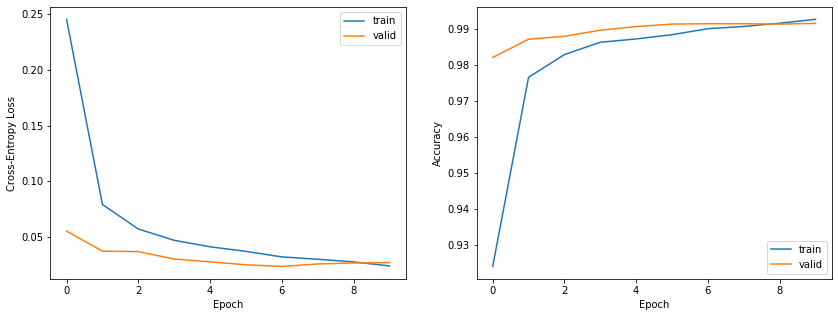

In [37]:
# Plot loss trajectory throughout training.
plt.figure(1, figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

## Performance Evaluation

In [38]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %.2f%%' % (score[1]*100))

Test cross-entropy loss: 0.02674
Test accuracy: 99.16%


## Save model Weights and Architecture Together
Saving the model this way includes everything about the model 
* Model weights
* Model architecture
* Model compilation details, the loss and metrics
* Model optimizer

In [39]:
# Save the model in h5 format 
model.save("model.h5")
print("Saved model to disk")

Saved model to disk
